In [85]:
import pandas as pd
from pandas import json_normalize

from sleep_events import connect_to_firebase

db = connect_to_firebase()

docs = db.collection('erpEvents').where('experiment', '==', 'MMN').stream()
records = [doc.to_dict() for doc in docs]

df = pd.DataFrame(records)
exploded_df = json_normalize(df['mmn'])

rdf = pd.concat([df[[col for col in df if col != 'mmn']], exploded_df], axis=1)
rdf.head()

C:\Users\graha\.conda\envs\tf\lib\site-packages\google\cloud\firestore_v1\base_collection.py:300: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


,experiment,timestamp,frequency,eventType
0,MMN,2025-01-20 08:28:49.334000+00:00,1000,standard
1,MMN,2025-01-20 08:29:08.889000+00:00,1000,standard
2,MMN,2025-01-20 08:30:47.673000+00:00,1000,standard
3,MMN,2025-01-20 08:31:02.583000+00:00,1000,standard
4,MMN,2025-01-20 08:31:56.389000+00:00,1000,standard


In [2]:
input_dir = "C:\\dev\\play\\brainwave-data-day"


In [90]:
import pandas as pd
import os
from datetime import datetime, timezone

# Load the existing DataFrame with directory start times
input_dir = "C:\\dev\\play\\brainwave-data-day"
dirs = next(os.walk(input_dir))[1]

# List to store the directory names and their start times
data = []

# Iterate over the directories to extract start times
for dir_name in dirs:
    start_time = pd.to_datetime(dir_name, format='%Y-%m-%d-%H-%M-%S', utc=True)
    data.append({'dir_name': dir_name, 'start_time': start_time})

# Create a DataFrame from the data
dir_df = pd.DataFrame(data)
dir_df['start_time'] = pd.to_datetime(dir_df['start_time']).dt.tz_convert('UTC')

# Function to find the most likely file for a given timestamp
def find_file_for_timestamp(timestamp, dir_df):
    # Find the directory with the latest start time before the timestamp
    dir_df = dir_df.sort_values(by='start_time')
    for idx, row in dir_df.iterrows():
        if row['start_time'] <= timestamp:
            likely_dir = row['dir_name']
        else:
            break
    return likely_dir

# Ensure rdf['timestamp'] is timezone-aware and convert to UTC if necessary
rdf['timestamp'] = pd.to_datetime(rdf['timestamp']).dt.tz_convert('UTC')

# Iterate over the rows in rdf and find the corresponding file
rdf['likely_file'] = rdf['timestamp'].apply(lambda ts: find_file_for_timestamp(ts, dir_df))

# Calculate the starting sample for each row
sampling_rate = 250  # Assuming a sampling rate of 250 Hz

def calculate_starting_sample(row, dir_df):
    file_start_time = dir_df.loc[dir_df['dir_name'] == row['likely_file'], 'start_time'].iloc[0]
    time_diff = (row['timestamp'] - file_start_time).total_seconds()
    starting_sample = int(time_diff * sampling_rate)
    return starting_sample

rdf['starting_sample'] = rdf.apply(lambda row: calculate_starting_sample(row, dir_df), axis=1)

rdf.head()

,experiment,timestamp,frequency,eventType,likely_file,starting_sample
0,MMN,2025-01-20 08:28:49.334000+00:00,1000,standard,2025-01-20-08-26-13,39083
1,MMN,2025-01-20 08:29:08.889000+00:00,1000,standard,2025-01-20-08-26-13,43972
2,MMN,2025-01-20 08:30:47.673000+00:00,1000,standard,2025-01-20-08-26-13,68668
3,MMN,2025-01-20 08:31:02.583000+00:00,1000,standard,2025-01-20-08-26-13,72395
4,MMN,2025-01-20 08:31:56.389000+00:00,1000,standard,2025-01-20-08-26-13,85847


In [87]:
rdf['eventType'].unique()

array(['standard', 'deviant'], dtype=object)

In [91]:
likely_files = rdf['likely_file'].unique()
likely_files

array(['2025-01-20-08-26-13', '2025-01-20-09-13-28'], dtype=object)

In [92]:
from convert import load_mne_file
import os
import pandas as pd

# Initialize an empty dictionary to store the files
file_map = {}

# Iterate over the unique likely files
for file_name in likely_files:
    # Construct the full path to the file
    file_path = os.path.join(input_dir, file_name, "raw.fif")

    # Check if the file exists
    if os.path.exists(file_path):
        # Load the file and store it in the map

        raw, _, filtered = load_mne_file(print, file_path)
        file_map[file_name] = filtered

# Display the keys of the map to verify
print(file_map.keys())

Reading file C:\dev\play\brainwave-data-day\2025-01-20-08-26-13\raw.fif
Opening raw data file C:\dev\play\brainwave-data-day\2025-01-20-08-26-13\raw.fif...
Isotrak not found
    Range : 0 ... 497762 =      0.000 ...  1991.048 secs
Ready.
Reading 0 ... 497762  =      0.000 ...  1991.048 secs...
Finished reading file C:\dev\play\brainwave-data-day\2025-01-20-08-26-13\raw.fif
Reading file C:\dev\play\brainwave-data-day\2025-01-20-09-13-28\raw.fif
Opening raw data file C:\dev\play\brainwave-data-day\2025-01-20-09-13-28\raw.fif...
Isotrak not found
    Range : 0 ... 5787602 =      0.000 ... 23150.408 secs
Ready.
Reading 0 ... 5787602  =      0.000 ... 23150.408 secs...
Finished reading file C:\dev\play\brainwave-data-day\2025-01-20-09-13-28\raw.fif
dict_keys(['2025-01-20-08-26-13', '2025-01-20-09-13-28'])


In [106]:
def get_data_for_row(row, file_map):
    file = row['likely_file']
    fif = file_map[file]
    data = fif.get_data(units='uV')
    interesting_data = data[0][row['starting_sample'] - 250:row['starting_sample'] + 250]
    # interesting_data = data[0][row['starting_sample'] - (250 * 5):row['starting_sample'] + (250 * 5)]
    return interesting_data

get_data_for_row(rdf.iloc[1], file_map).shape

(500,)

In [107]:
interesting = rdf[rdf['likely_file'] == '2025-01-20-09-13-28']

deviant = interesting[interesting['eventType'] == 'deviant']
standard = interesting[interesting['eventType'] == 'standard']

standard = standard.iloc[8:-8]


In [102]:
standard

,experiment,timestamp,frequency,eventType,likely_file,starting_sample
50,MMN,2025-01-20 15:38:24.725000+00:00,1000,standard,2025-01-20-09-13-28,5774181
51,MMN,2025-01-20 15:38:25.529000+00:00,1000,standard,2025-01-20-09-13-28,5774382
52,MMN,2025-01-20 15:38:26.445000+00:00,1000,standard,2025-01-20-09-13-28,5774611
53,MMN,2025-01-20 15:38:27.351000+00:00,1000,standard,2025-01-20-09-13-28,5774837
54,MMN,2025-01-20 15:38:27.970000+00:00,1000,standard,2025-01-20-09-13-28,5774992
55,MMN,2025-01-20 15:38:29.016000+00:00,1000,standard,2025-01-20-09-13-28,5775254
57,MMN,2025-01-20 15:38:30.487000+00:00,1000,standard,2025-01-20-09-13-28,5775621
58,MMN,2025-01-20 15:38:31.166000+00:00,1000,standard,2025-01-20-09-13-28,5775791
59,MMN,2025-01-20 15:38:32.224000+00:00,1000,standard,2025-01-20-09-13-28,5776056
60,MMN,2025-01-20 15:38:33.099000+00:00,1000,standard,2025-01-20-09-13-28,5776274


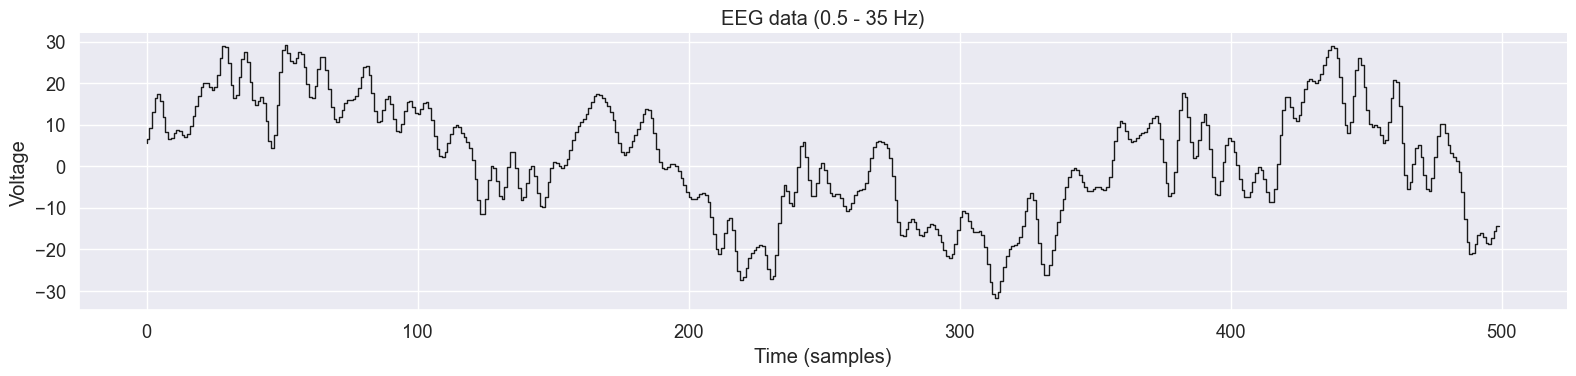

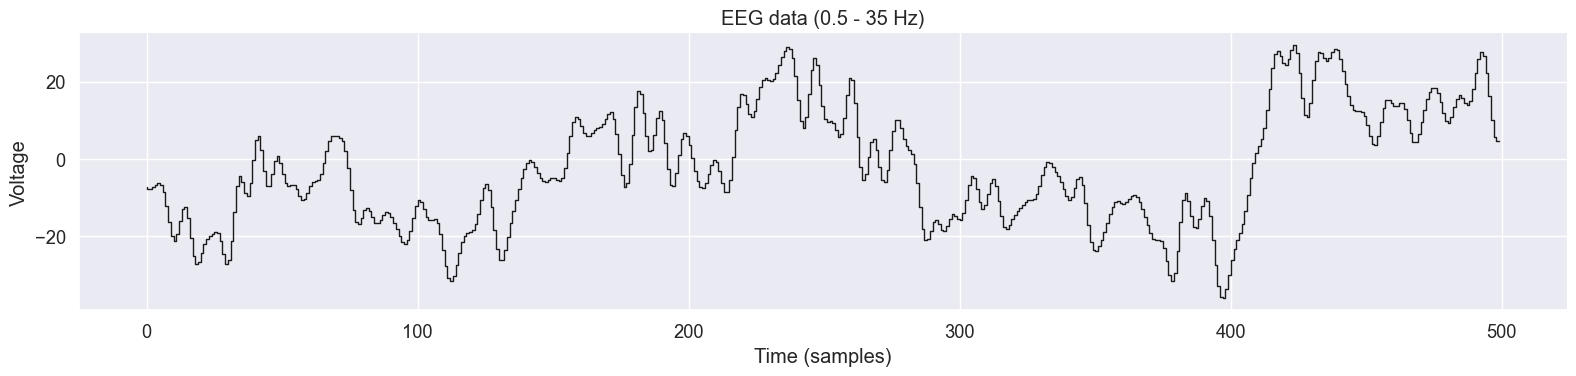

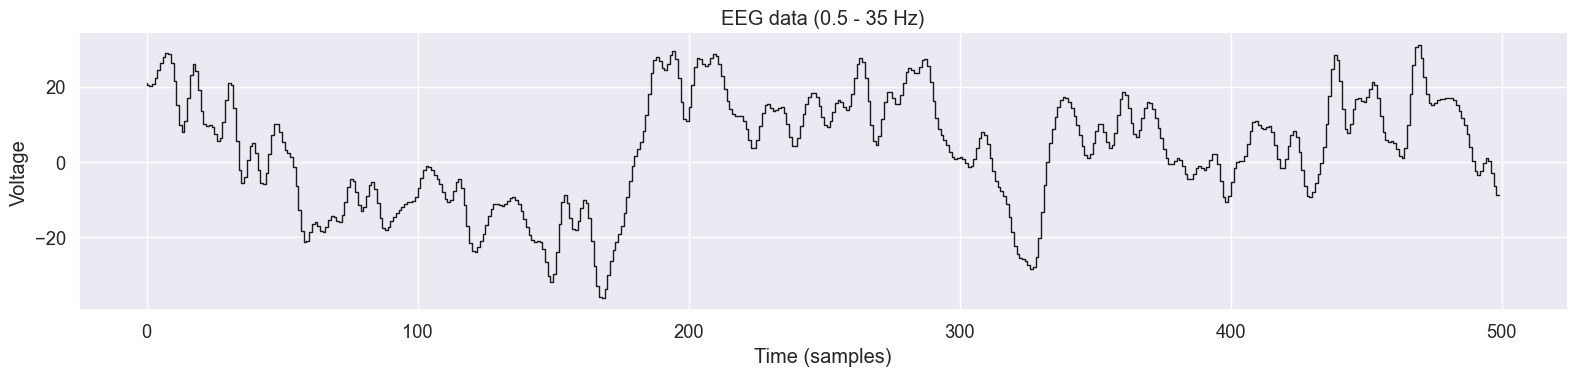

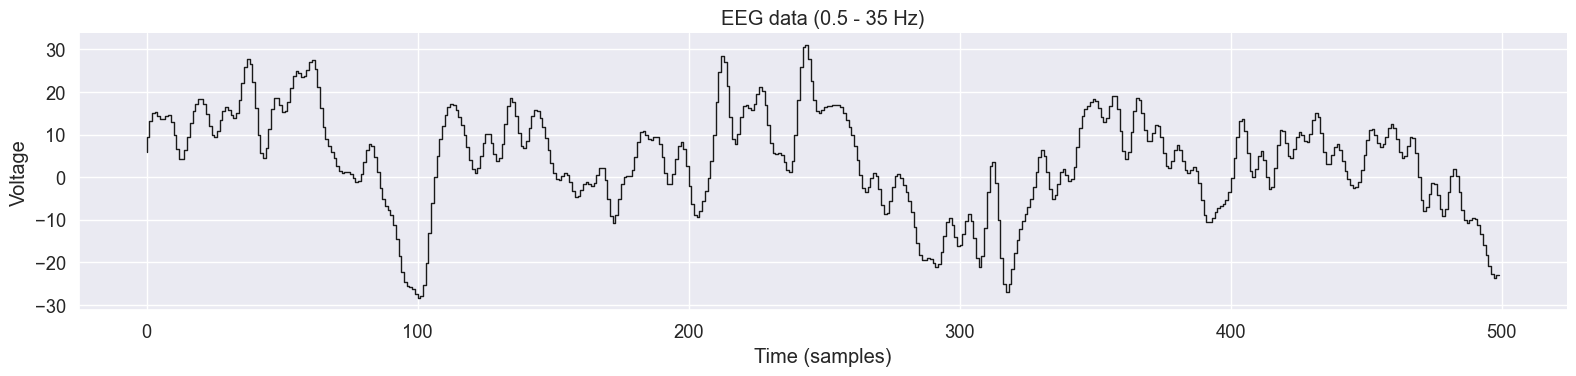

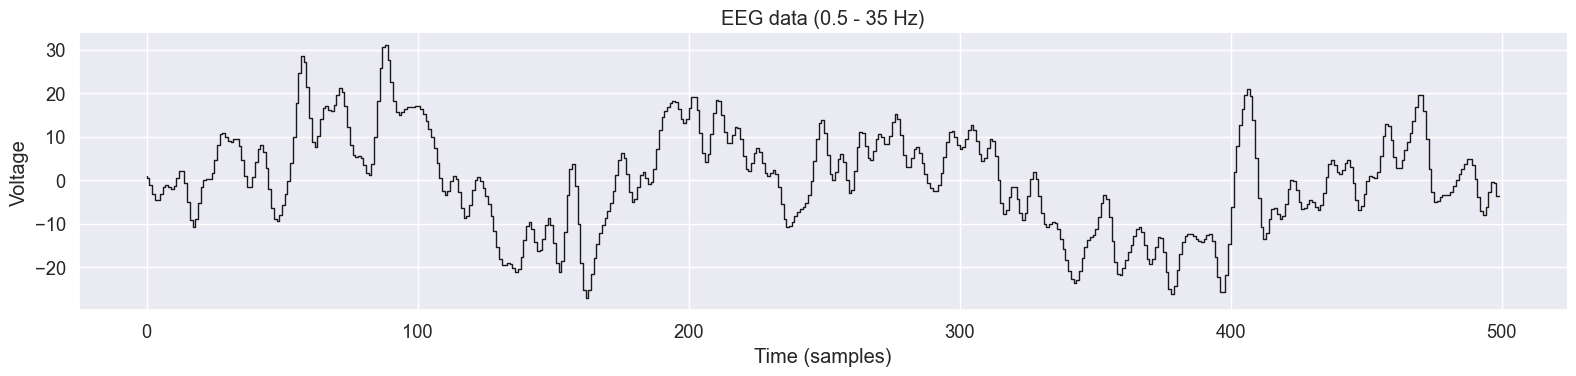

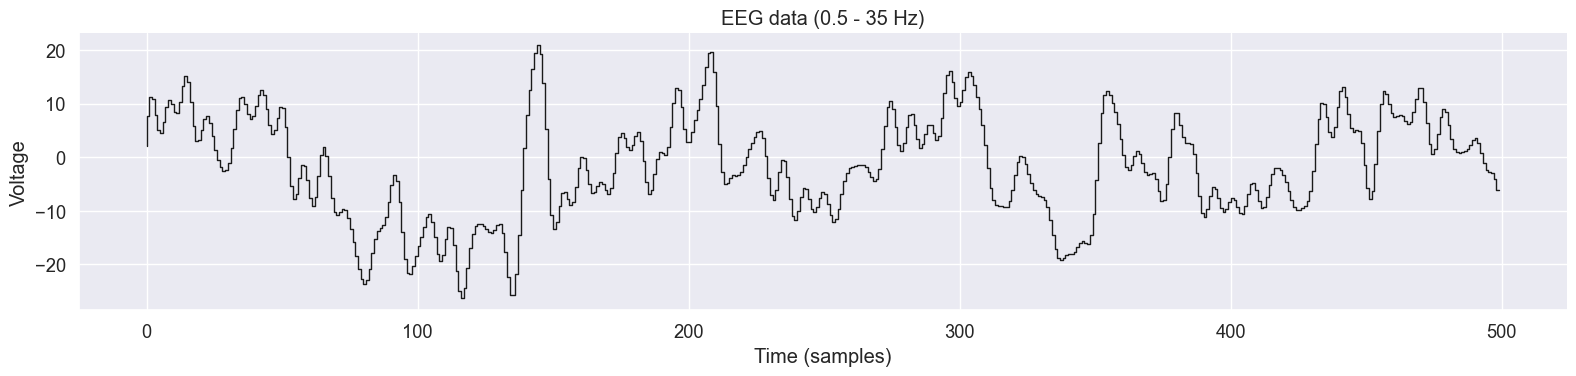

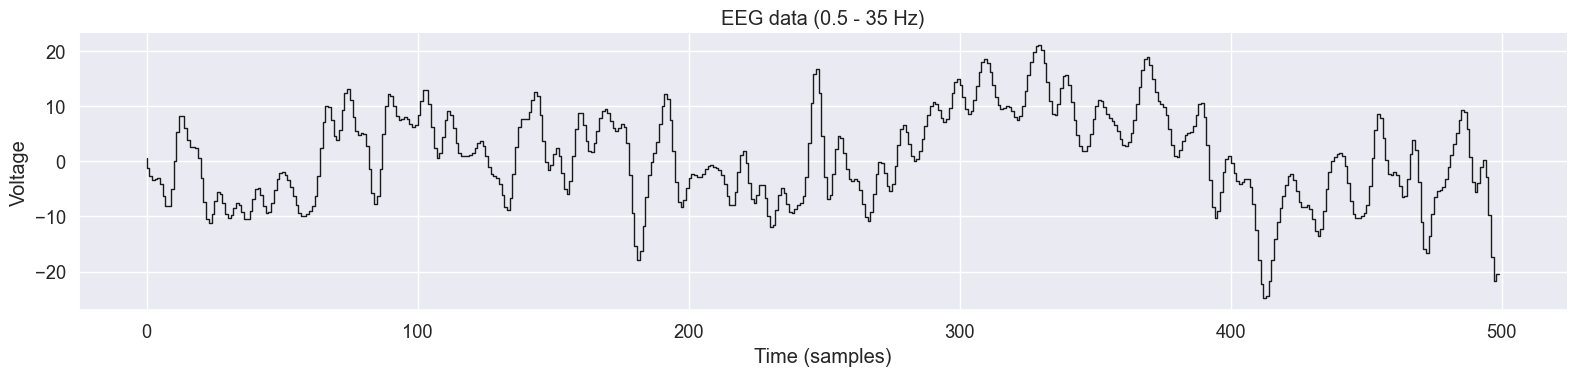

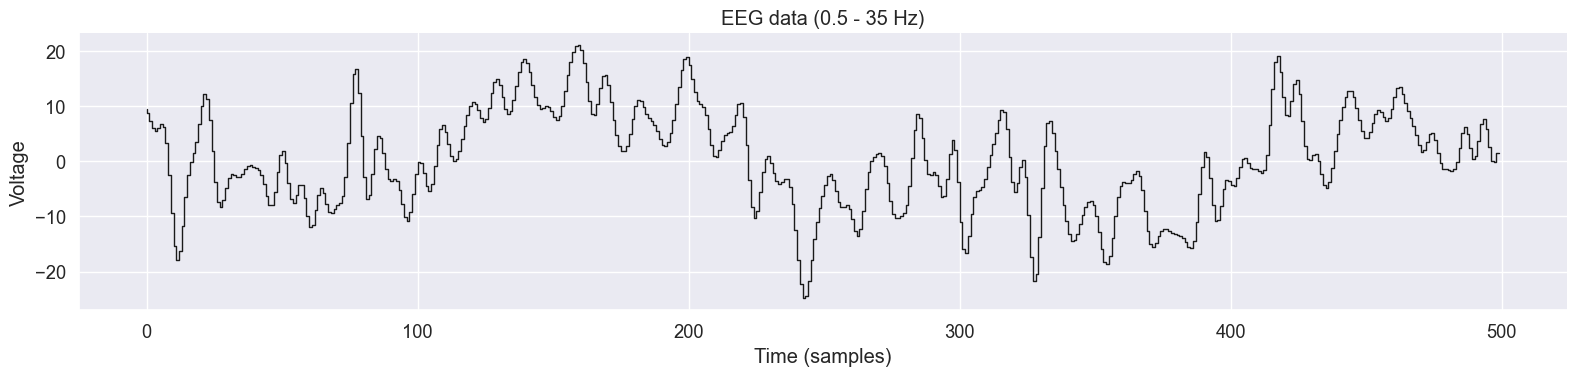

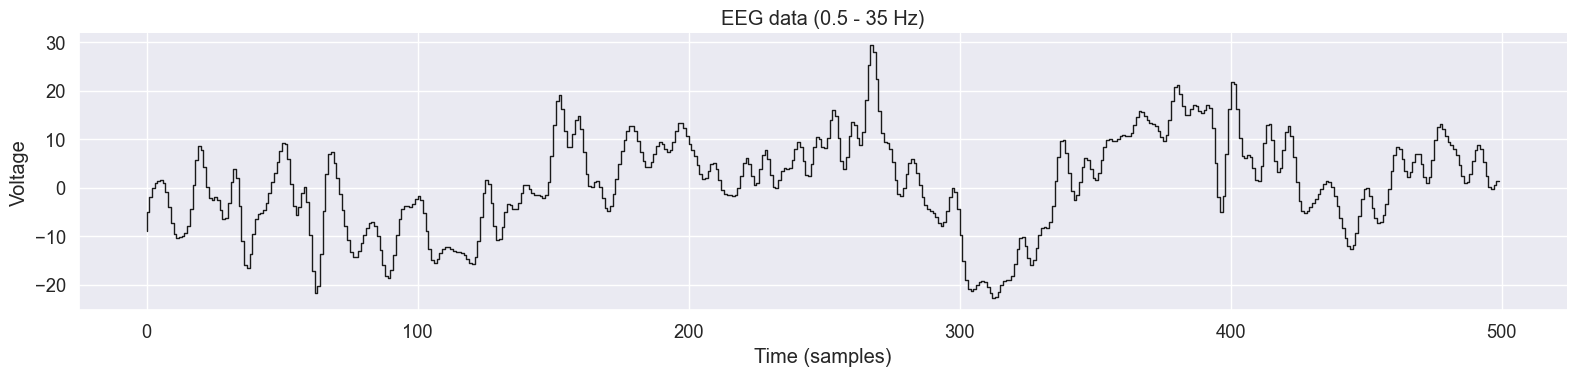

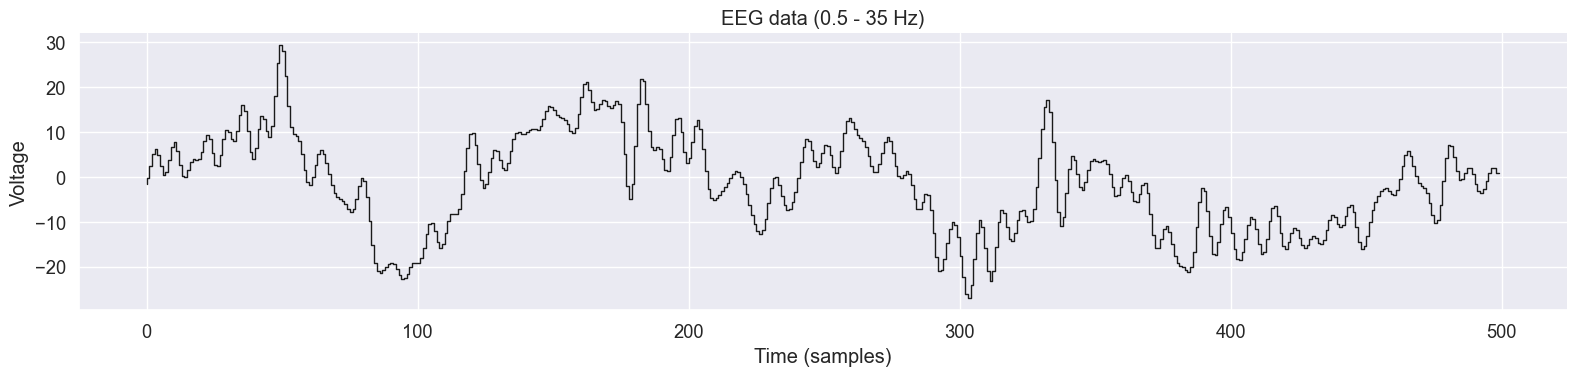

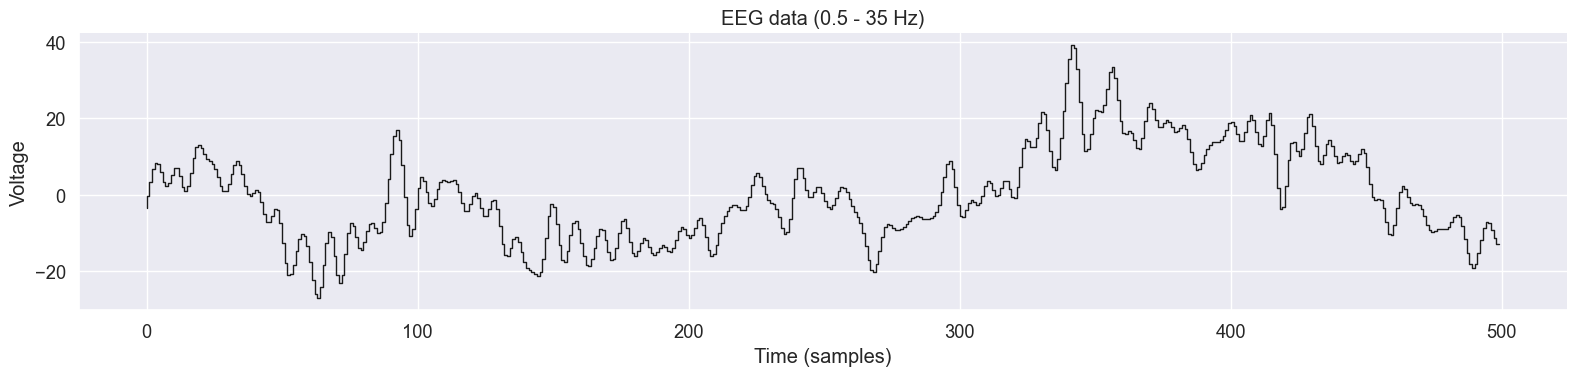

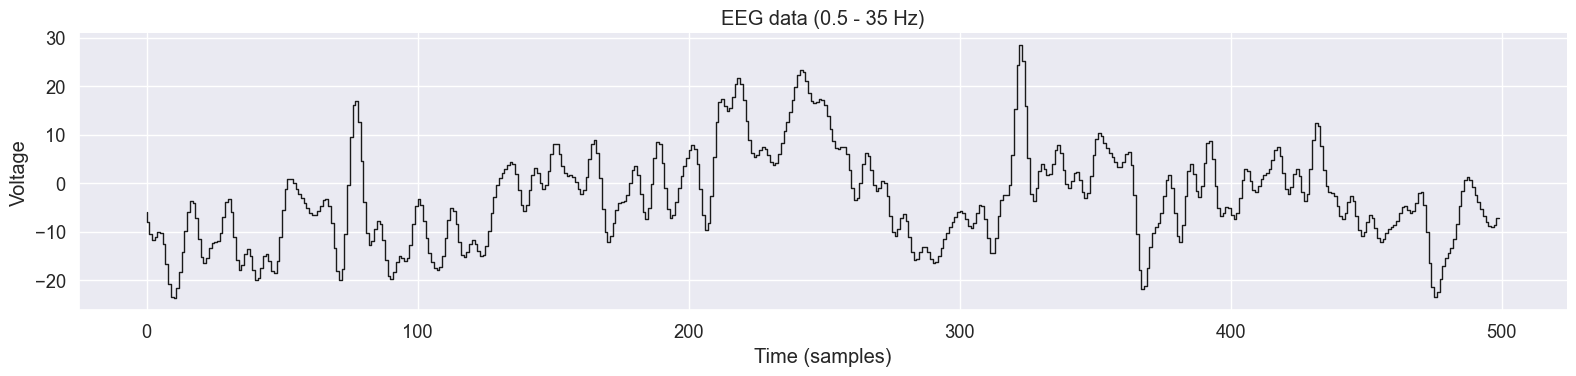

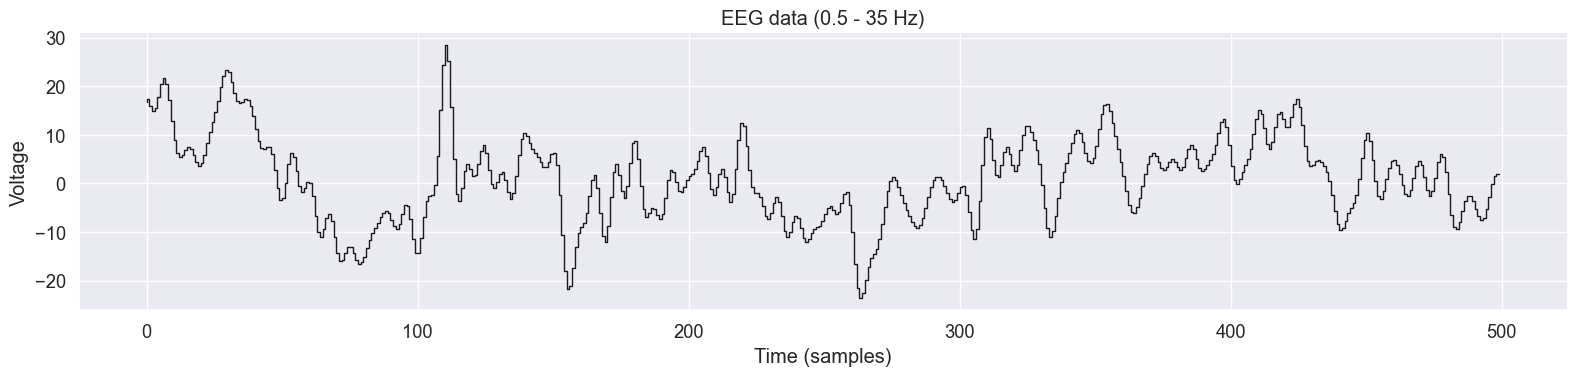

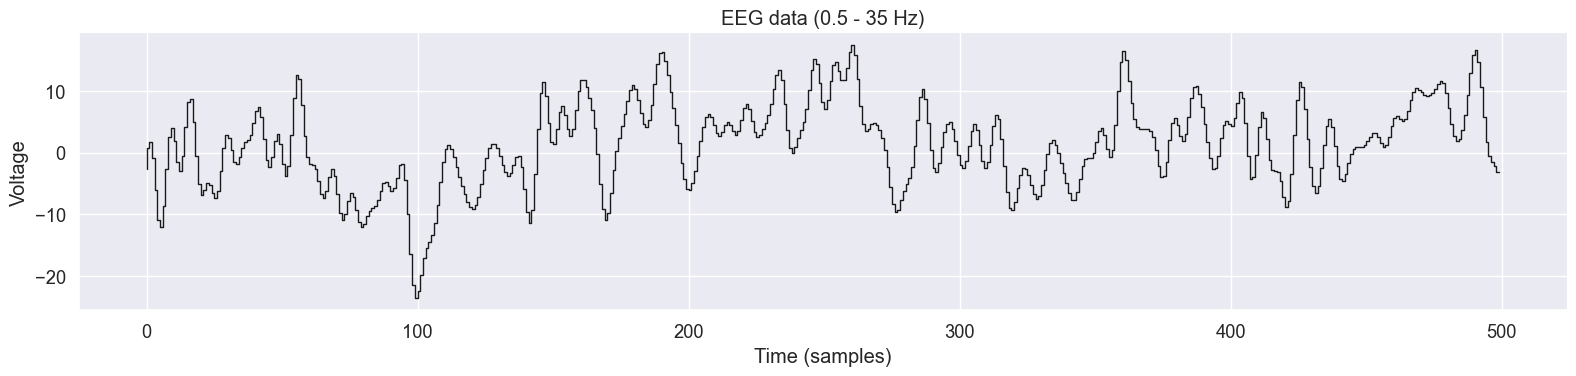

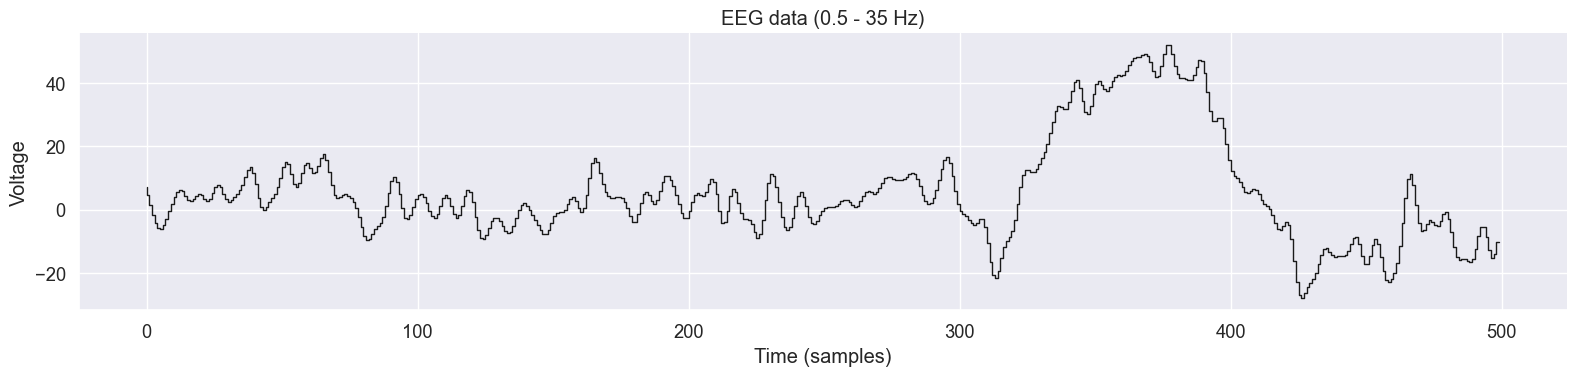

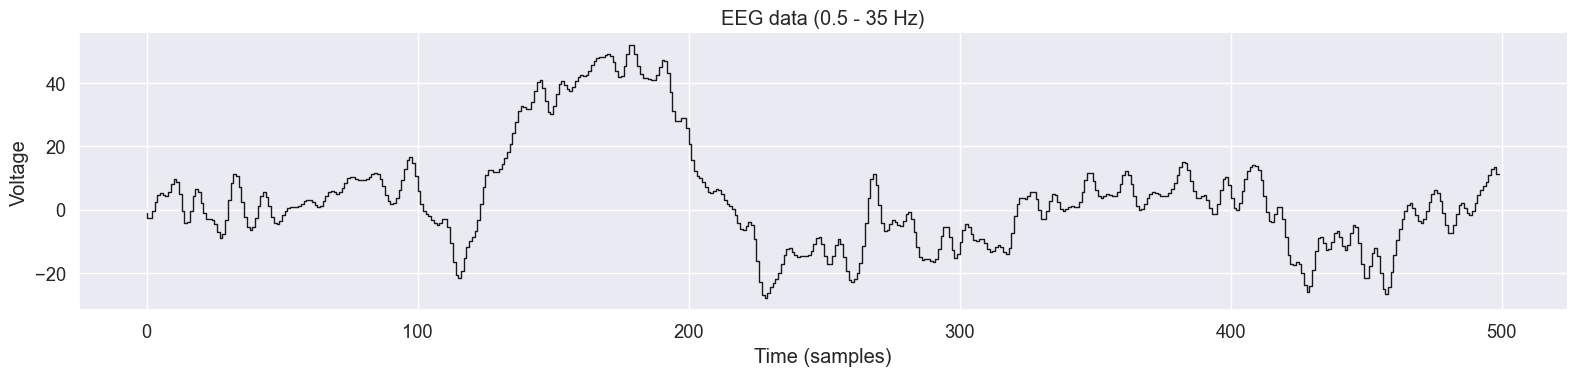

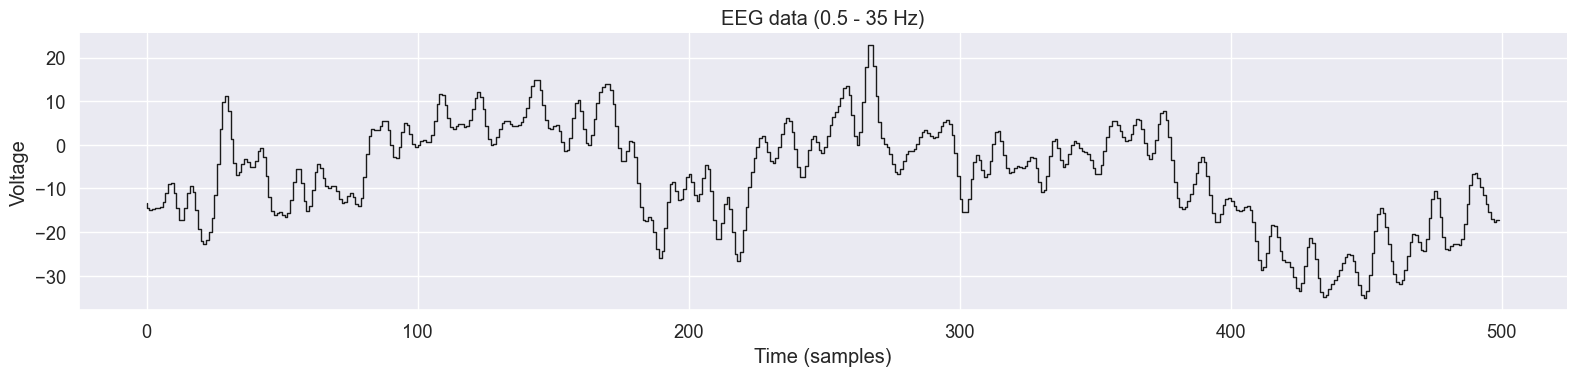

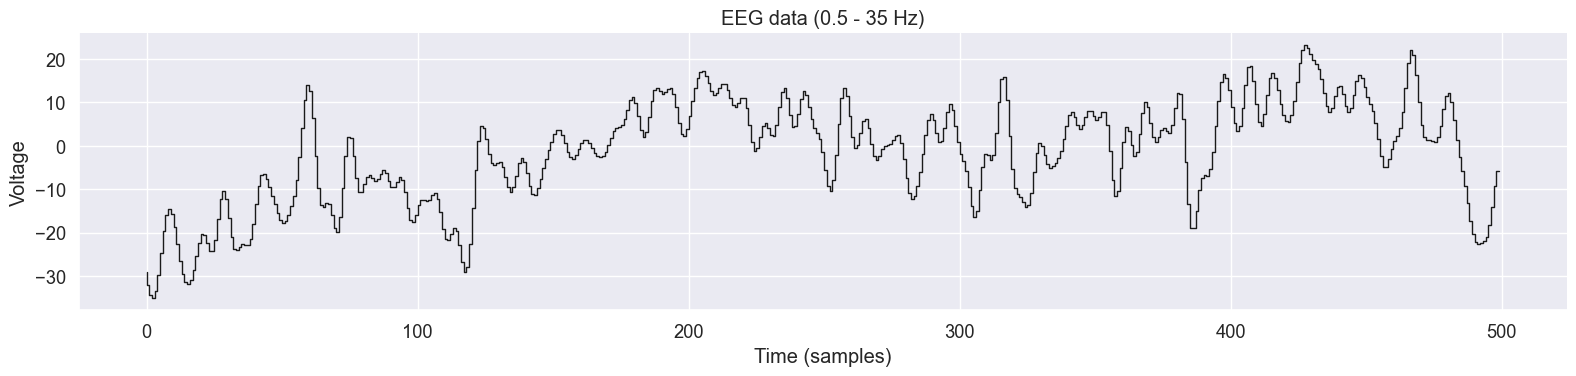

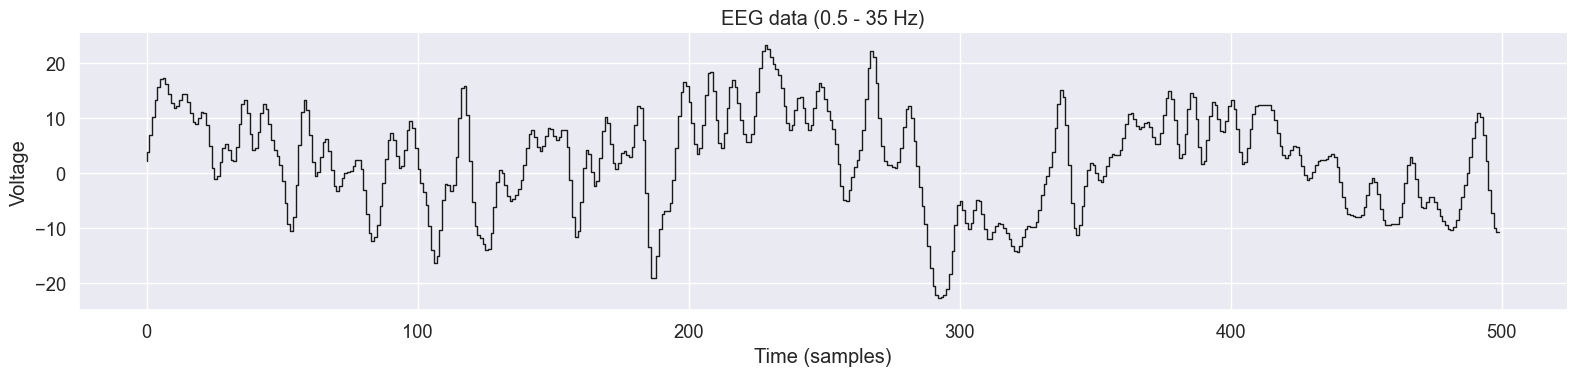

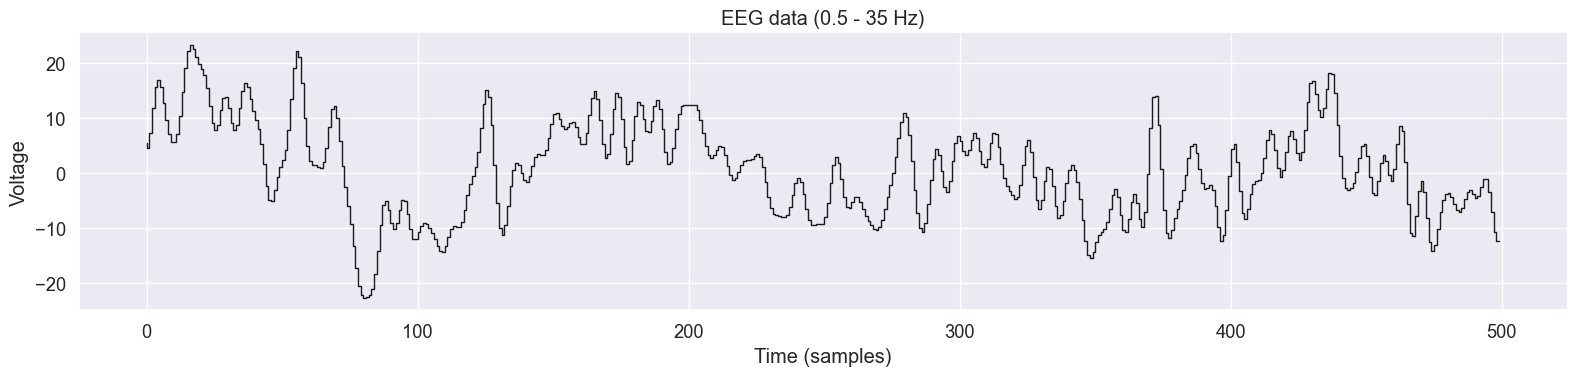

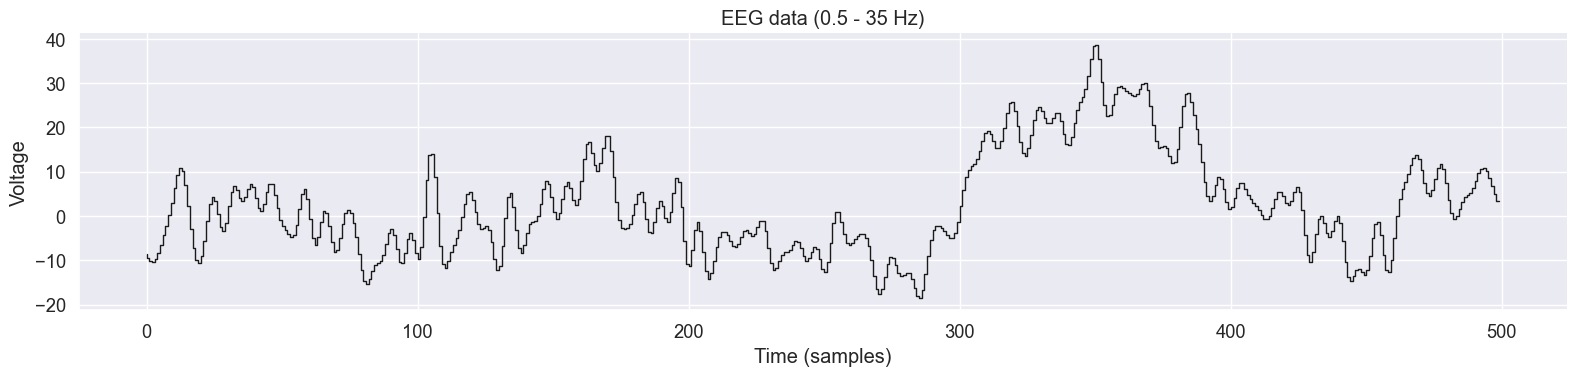

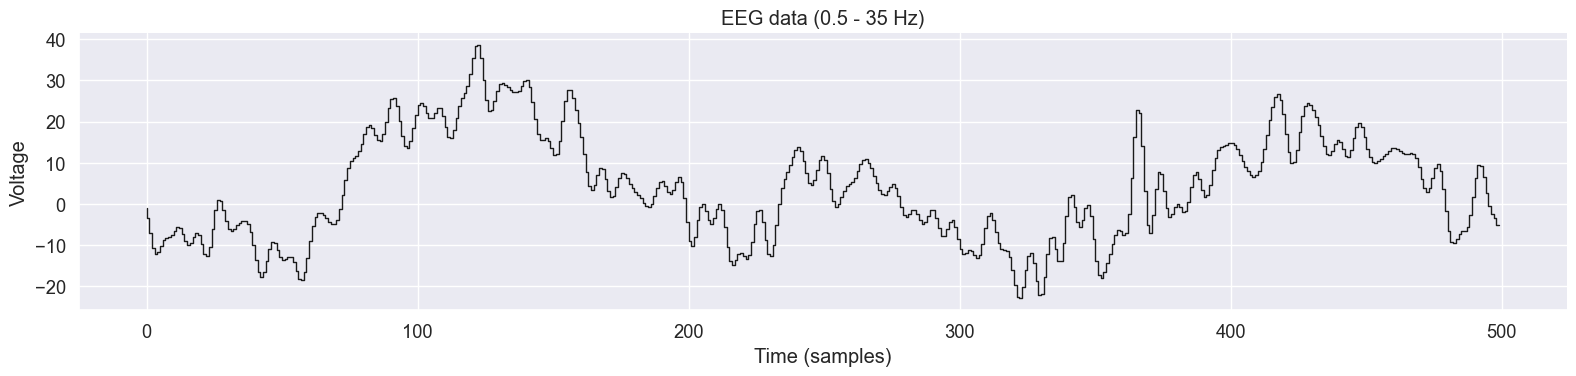

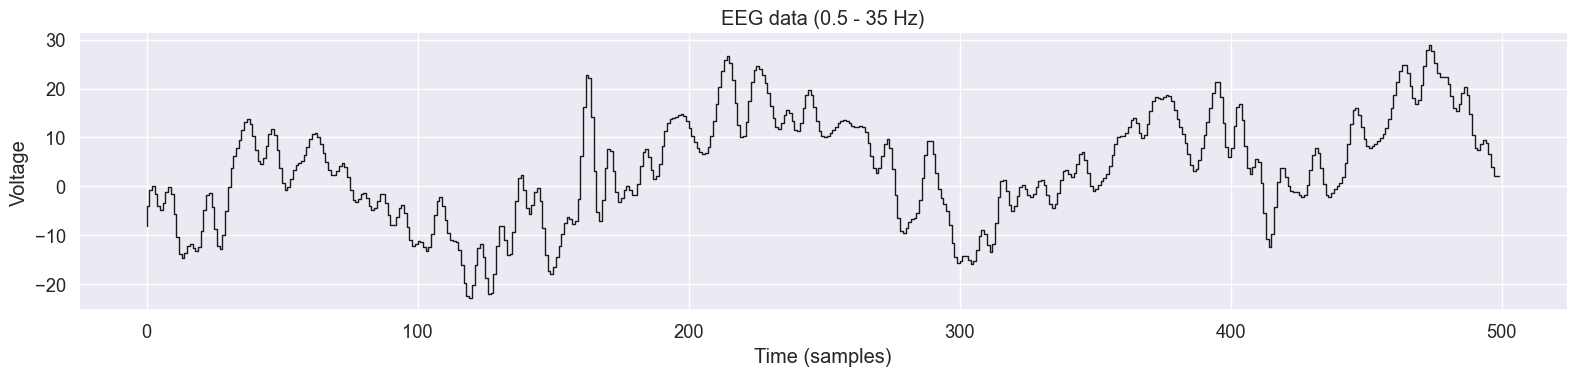

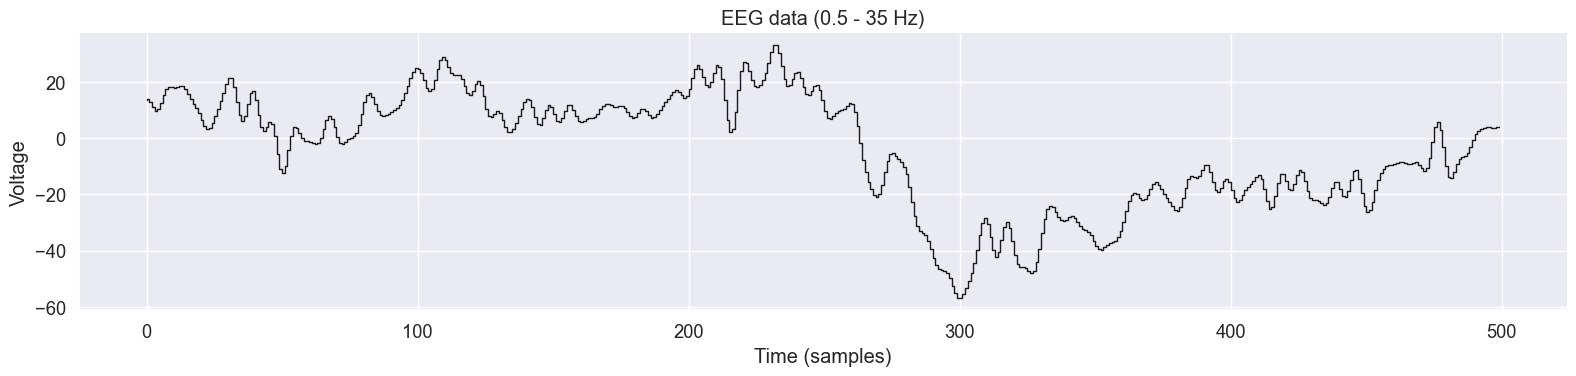

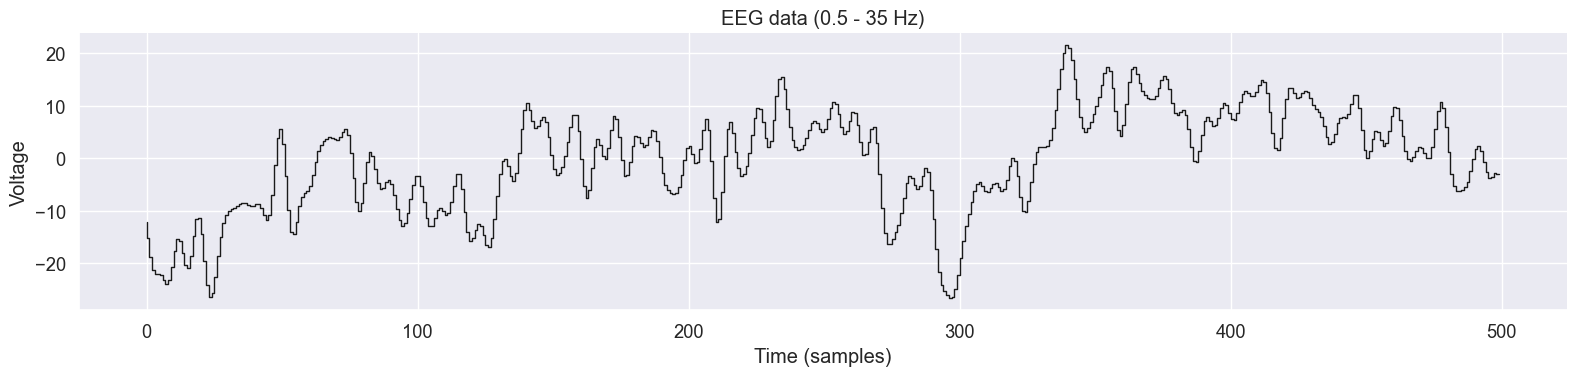

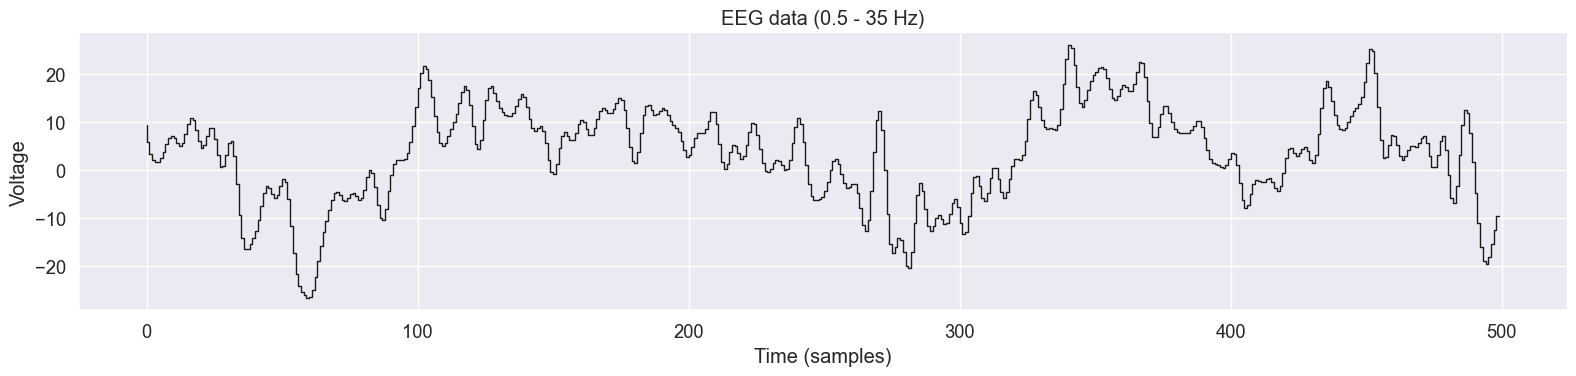

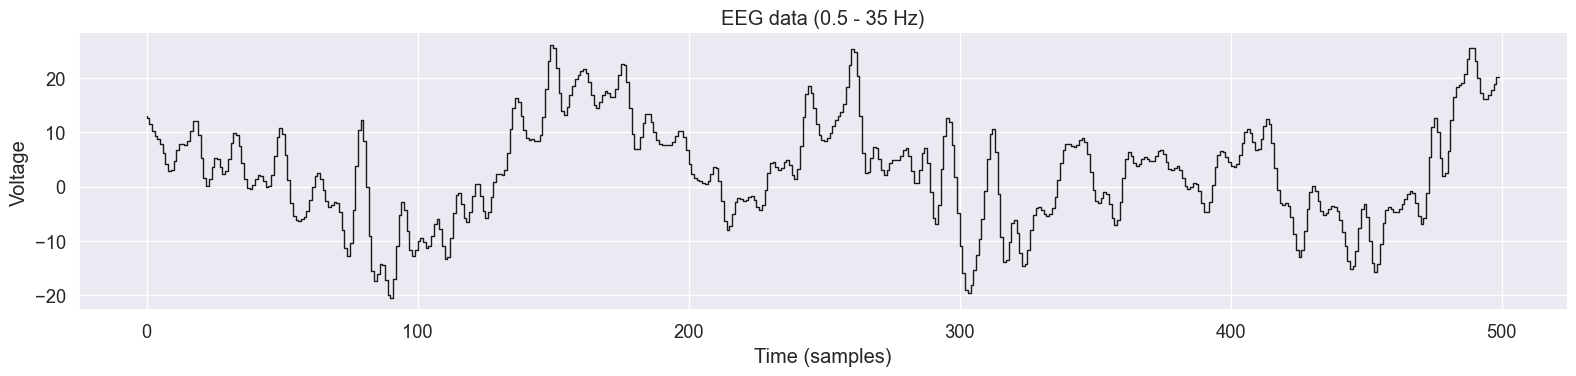

In [108]:
for _, row in standard.iterrows():
    data = get_data_for_row(row, file_map)
    plot_eeg_data(data)


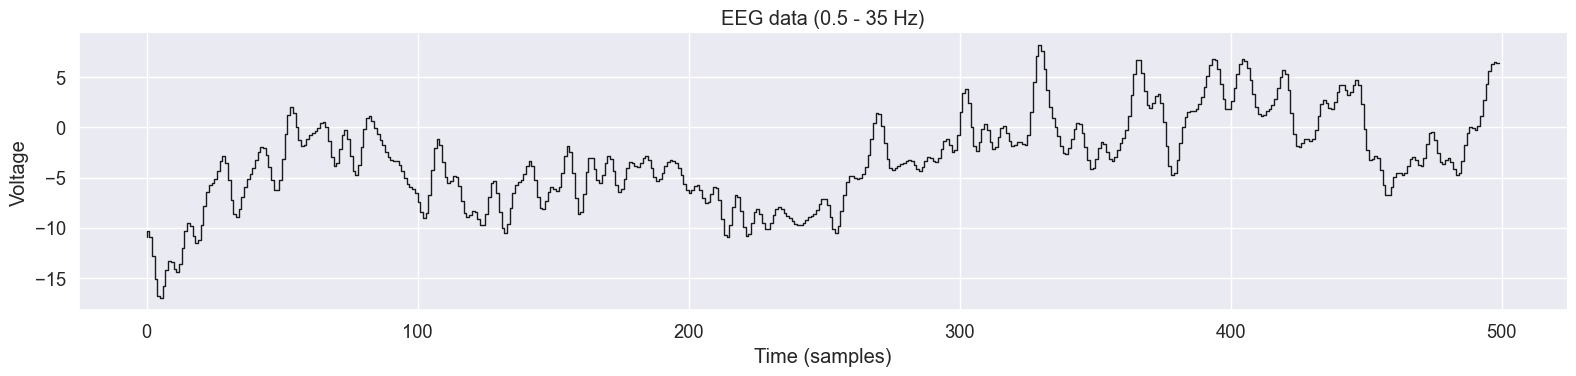

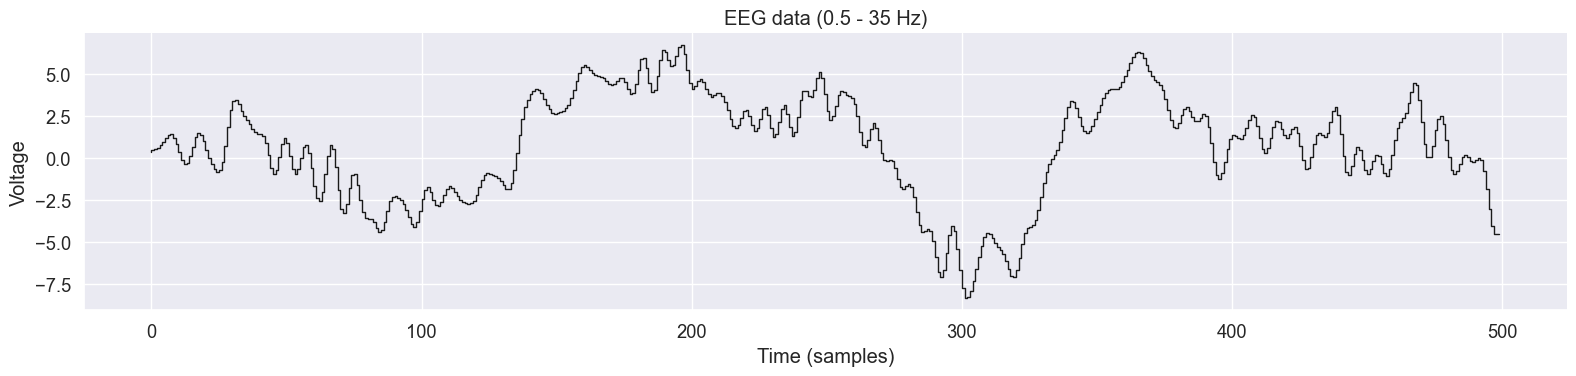

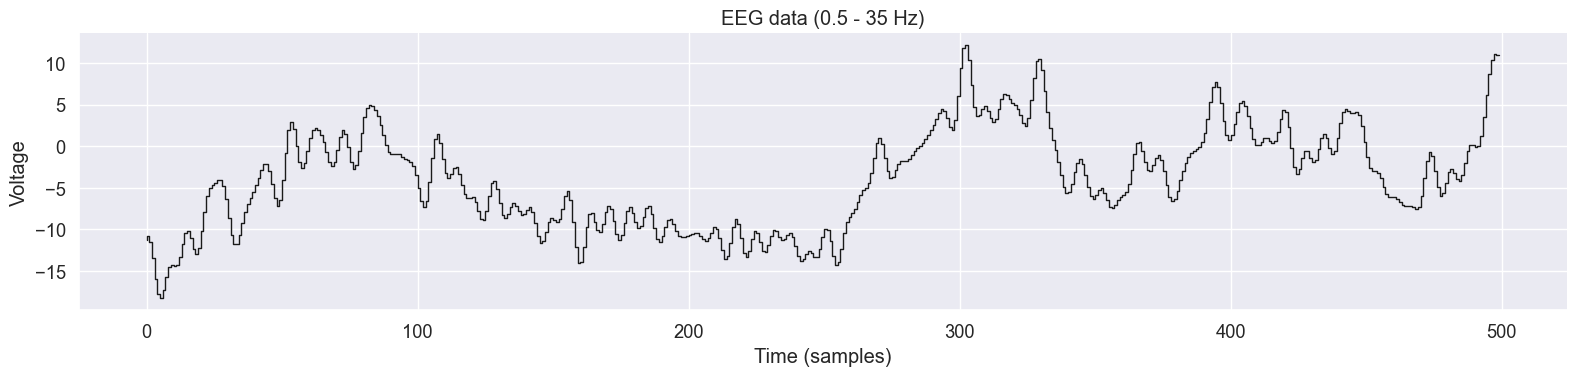

In [109]:
import numpy as np

def get_average_data_for_rows(rows, file_map):
    all_data = []
    for _, row in rows.iterrows():
        data = get_data_for_row(row, file_map)
        all_data.append(data)
    all_data_array = np.array(all_data)
    average_data = np.mean(all_data_array, axis=0)
    return average_data

average_deviant = get_average_data_for_rows(deviant, file_map)
average_standard = get_average_data_for_rows(standard, file_map)

average_diff = average_deviant - average_standard

plot_eeg_data(average_deviant)
plot_eeg_data(average_standard)
plot_eeg_data(average_diff)


In [64]:
fif = file_map['2025-01-20-08-26-13']
data = fif.get_data(units='uV')

In [53]:
type(data)

numpy.ndarray

In [68]:
interesting_data = data[0][rdf.iloc[1]['starting_sample'] - 250:rdf.iloc[1]['starting_sample'] + 250]
interesting_data.shape

(500,)

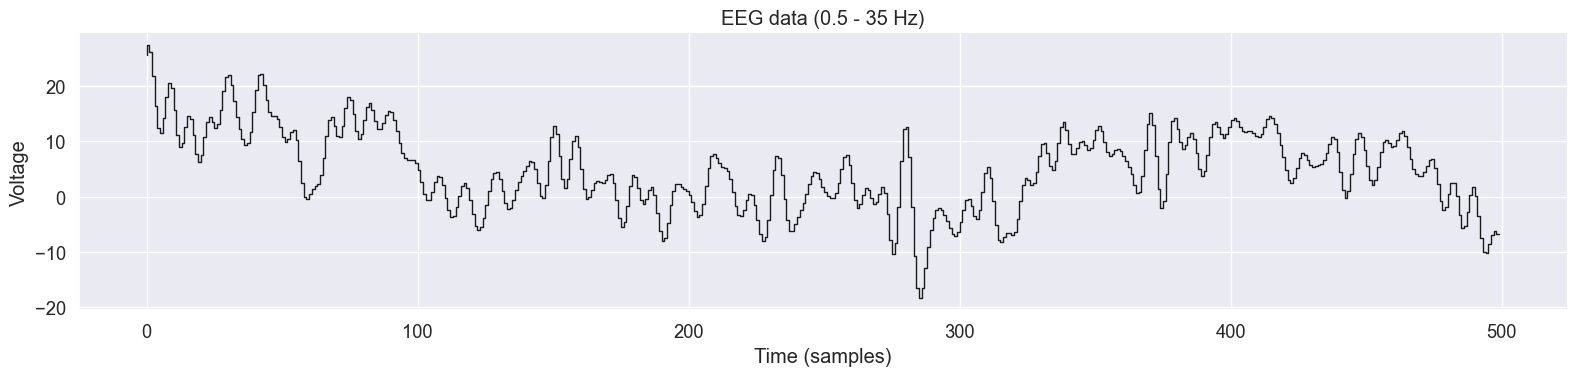

In [69]:
from notebooks.Util.DrawEpochs import plot_eeg_data

plot_eeg_data(interesting_data)